# Food Calorie Estimation – Nutrition5k Debug Experiment

This notebook runs a **small debug experiment** for the Food Calorie Estimation project:

- Uses the public **Nutrition5k** dataset (overhead RGB images).
- Builds a small **debug subset** of dishes (≈200 sampled → ≈132 with valid images).
- Trains:
  - A **ResNet-50 baseline** regressor.
  - A **ViT-B/16** regressor.
- Evaluates on a tiny test split and generates basic plots.
- Shows a simple **inference demo**.

> ⚠️ This is a *debug* notebook: metrics are **not representative** of full-dataset performance.

## Notebook roadmap

1. **Environment setup**
   - Clone repo, install dependencies.
   - Configure paths, device, random seed.

2. **Download Nutrition5k metadata**
   - Copy Nutrition5k `metadata/` and `dish_ids/` from GCS to Google Drive.

3. **Build debug subset**
   - Load `dish_metadata_cafe1/cafe2`.
   - Clean and merge metadata.
   - Sample ≈200 dishes with non-null calories.
   - Download overhead `rgb.png` images for those dishes.
   - Filter missing images and split into train/val/test.

4. **Data pipeline**
   - Create `Nutrition5kOverheadDataset` and DataLoaders.
   - Quick sanity check on batch shapes.

5. **Train models (debug scale)**
   - ResNet-50 baseline.
   - ViT-B/16.

6. **Evaluation & plots**
   - Compute regression metrics (MAE, RMSE, etc.).
   - Plot true vs predicted and error histograms.

7. **Inference demo & next steps**
   - Predict calories for a sample test dish.
   - Note limitations and future work.

In [1]:
# If you open this notebook directly from GitHub in Colab,
# cloning again is fine (you'll just have /content/food-calorie-estimation).

GITHUB_REPO_URL = "https://github.com/swanframe/food-calorie-estimation.git"  # change if your URL is different

!git clone $GITHUB_REPO_URL
%cd food-calorie-estimation

# Minimal extra dependencies (torch/torchvision are already in Colab)
!pip install timm pyyaml

Cloning into 'food-calorie-estimation'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 53 (delta 20), reused 42 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 17.98 KiB | 17.98 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/food-calorie-estimation


In [2]:
from pathlib import Path
import sys

import pandas as pd

import torch
from torch.utils.data import DataLoader

from src.data.nutrition5k_dataset import Nutrition5kOverheadDataset, get_transforms
from src.models.baseline_cnn import ResNetCalorieRegressor
from src.models.vit_regressor import ViTCalorieRegressor
from src.training.train_loop import train_model
from src.training.utils import set_seed
from src.evaluation.metrics import compute_regression_metrics, print_regression_metrics
from src.evaluation.plots import plot_true_vs_pred, plot_error_histogram

# Make sure repo root is on sys.path (usually already true after %cd)
REPO_ROOT = Path.cwd()
print("Repo root:", REPO_ROOT)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

set_seed(42)

Repo root: /content/food-calorie-estimation
Using device: cuda


In [3]:
from google.colab import drive

drive.mount("/content/drive")

DATA_ROOT = Path("/content/drive/MyDrive/data/nutrition5k")
MODEL_DIR = Path("/content/drive/MyDrive/models/food-calorie-estimation")
REPORTS_DIR = REPO_ROOT / "reports"

for path in [DATA_ROOT, MODEL_DIR, REPORTS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

DATA_ROOT, MODEL_DIR, REPORTS_DIR

Mounted at /content/drive


(PosixPath('/content/drive/MyDrive/data/nutrition5k'),
 PosixPath('/content/drive/MyDrive/models/food-calorie-estimation'),
 PosixPath('/content/food-calorie-estimation/reports'))

## 1. Download Nutrition5k metadata & splits

We copy the official Nutrition5k **metadata** and **dish_ids** from Google Cloud Storage
into our Google Drive under `MyDrive/data/nutrition5k`.

You only need to run this once per Colab/Drive setup. If the data is already there,
you can skip or re-run to double-check.

In [4]:
DATA_ROOT_STR = str(DATA_ROOT)

# This will create DATA_ROOT / "metadata" and DATA_ROOT / "dish_ids"
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata" "$DATA_ROOT_STR"
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids" "$DATA_ROOT_STR"

METADATA_DIR = DATA_ROOT / "metadata"
DISH_IDS_DIR = DATA_ROOT / "dish_ids"
METADATA_DIR, DISH_IDS_DIR

Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv...
/ [3/3 files][  2.2 MiB/  2.2 MiB] 100% Done                                    
Operation completed over 3 objects/2.2 MiB.                                      
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe2.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/README...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe1.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_all.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_train_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/sp

(PosixPath('/content/drive/MyDrive/data/nutrition5k/metadata'),
 PosixPath('/content/drive/MyDrive/data/nutrition5k/dish_ids'))

In [5]:
METADATA_DIR = DATA_ROOT / "metadata"

base_cols = [
    "dish_id",
    "total_calories",
    "total_mass",
    "total_fat",
    "total_carb",
    "total_protein",
    "num_ingrs",
]

# 1) Read both cafe metadata files with tolerant parser
cafe1 = pd.read_csv(
    METADATA_DIR / "dish_metadata_cafe1.csv",
    engine="python",
    header=None,
    on_bad_lines="skip",
)
cafe2 = pd.read_csv(
    METADATA_DIR / "dish_metadata_cafe2.csv",
    engine="python",
    header=None,
    on_bad_lines="skip",
)

# 2) Create dummy names for ingredient columns
extra_cols1 = [f"extra_{i}" for i in range(cafe1.shape[1] - len(base_cols))]
extra_cols2 = [f"extra_{i}" for i in range(cafe2.shape[1] - len(base_cols))]

cafe1.columns = base_cols + extra_cols1
cafe2.columns = base_cols + extra_cols2

# 3) Keep only the dish-level columns
cafe1 = cafe1[base_cols]
cafe2 = cafe2[base_cols]

# 4) Drop header-like rows where dish_id literally == "dish_id"
cafe1 = cafe1[cafe1["dish_id"] != "dish_id"]
cafe2 = cafe2[cafe2["dish_id"] != "dish_id"]

# 5) Ensure numeric types
for col in ["total_calories", "total_mass", "total_fat", "total_carb", "total_protein", "num_ingrs"]:
    cafe1[col] = pd.to_numeric(cafe1[col], errors="coerce")
    cafe2[col] = pd.to_numeric(cafe2[col], errors="coerce")

dish_meta = pd.concat([cafe1, cafe2], ignore_index=True)
dish_meta.head(), dish_meta.shape

(           dish_id  total_calories  total_mass  total_fat  total_carb  \
 0  dish_1561662216      300.794281       193.0  12.387489   28.218290   
 1  dish_1562688426      137.569992        88.0   8.256000    5.190000   
 2  dish_1561662054      419.438782       292.0  23.838249   26.351543   
 3  dish_1562008979      382.936646       290.0  22.224644   10.173570   
 4  dish_1560455030       20.590000       103.0   0.148000    4.625000   
 
    total_protein  num_ingrs  
 0      18.633970        NaN  
 1      10.297000        NaN  
 2      25.910593        NaN  
 3      35.345387        NaN  
 4       0.956000        NaN  ,
 (4583, 7))

In [6]:
print("dish_meta shape:", dish_meta.shape)
print(dish_meta.isna().mean())

dish_meta["total_calories"].describe()

dish_meta shape: (4583, 7)
dish_id           0.0
total_calories    0.0
total_mass        0.0
total_fat         0.0
total_carb        0.0
total_protein     0.0
num_ingrs         1.0
dtype: float64


,total_calories
count,4583.000000
mean,195.688704
std,309.117025
min,0.000000
25%,45.995001
50%,126.574638
75%,281.006134
max,9485.815430


In [7]:
# Keep only rows with non-null total_calories
dish_meta_clean = dish_meta.dropna(subset=["total_calories"]).reset_index(drop=True)

DEBUG_N_DISHES = 200

debug_dishes = dish_meta_clean.sample(
    n=DEBUG_N_DISHES,
    random_state=42,
).copy().reset_index(drop=True)

debug_dishes.shape, debug_dishes["total_calories"].describe()

((200, 7),
 count    200.000000
 mean     200.203568
 std      202.755480
 min        0.000000
 25%       42.483707
 50%      116.717163
 75%      275.727989
 max      907.119995
 Name: total_calories, dtype: float64)

In [8]:
import subprocess
from tqdm import tqdm

OVERHEAD_LOCAL_ROOT = DATA_ROOT / "imagery" / "realsense_overhead"
OVERHEAD_LOCAL_ROOT.mkdir(parents=True, exist_ok=True)

missing_rgb = []

for dish_id in tqdm(debug_dishes["dish_id"].tolist()):
    dish_id = str(dish_id)
    local_dish_dir = OVERHEAD_LOCAL_ROOT / dish_id
    local_dish_dir.mkdir(parents=True, exist_ok=True)

    gs_path = f"gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png"

    try:
        subprocess.run(
            ["gsutil", "cp", gs_path, str(local_dish_dir)],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
    except subprocess.CalledProcessError:
        missing_rgb.append(dish_id)

print("Missing rgb.png for", len(missing_rgb), "dishes")

# Filter out dishes without images
debug_dishes = debug_dishes[~debug_dishes["dish_id"].isin(missing_rgb)].reset_index(drop=True)
debug_dishes.shape

100%|██████████| 200/200 [06:08<00:00,  1.84s/it]

Missing rgb.png for 68 dishes


(132, 7)

## 2. PyTorch Datasets & DataLoaders (debug subset)

We now wrap the debug CSV splits into:

- `Nutrition5kOverheadDataset` (from `src/data/nutrition5k_dataset.py`)
- `DataLoader`s for train/val/test

and do a quick sanity check on batch shapes.

In [9]:
debug_splits_dir = DATA_ROOT / "debug_splits"

train_df = pd.read_csv(debug_splits_dir / "debug_train.csv")
val_df   = pd.read_csv(debug_splits_dir / "debug_val.csv")
test_df  = pd.read_csv(debug_splits_dir / "debug_test.csv")

train_transform, eval_transform = get_transforms(image_size=224)

OVERHEAD_LOCAL_ROOT = DATA_ROOT / "imagery" / "realsense_overhead"

train_dataset = Nutrition5kOverheadDataset(
    data=train_df,
    images_root=OVERHEAD_LOCAL_ROOT,
    target_col="total_calories",
    transform=train_transform,
)

val_dataset = Nutrition5kOverheadDataset(
    data=val_df,
    images_root=OVERHEAD_LOCAL_ROOT,
    target_col="total_calories",
    transform=eval_transform,
)

test_dataset = Nutrition5kOverheadDataset(
    data=test_df,
    images_root=OVERHEAD_LOCAL_ROOT,
    target_col="total_calories",
    transform=eval_transform,
)

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

len(train_dataset), len(val_dataset), len(test_dataset)

(92, 20, 20)

In [10]:
batch = next(iter(train_loader))
images, targets = batch

images.shape, targets.shape, images.dtype, targets.dtype

(torch.Size([16, 3, 224, 224]), torch.Size([16]), torch.float32, torch.float32)

## 3. Train Baseline ResNet-50 (debug subset)

We first train a **ResNet-50**-based regressor on the debug subset.

- Backbone: ImageNet-pretrained `resnet50`.
- Head: small regression layer (1 output).
- For this tiny dataset, we **freeze the backbone** and train only the head.

In [11]:
# Make sure seed/device are set
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

resnet_model = ResNetCalorieRegressor(
    backbone_name="resnet50",
    pretrained=True,
    dropout_p=0.3,
    freeze_backbone=True,   # good for tiny debug set
)

resnet_model.to(device)

optimizer_resnet = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=1e-4,
    weight_decay=1e-4,
)

resnet_ckpt_path = MODEL_DIR / "baseline_resnet_debug.pt"

history_resnet = train_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_resnet,
    device=device,
    loss_fn=torch.nn.MSELoss(),
    num_epochs=5,
    use_amp=True,
    checkpoint_path=resnet_ckpt_path,
)

history_resnet

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]
/content/food-calorie-estimation/src/training/train_loop.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
/content/food-calorie-estimation/src/training/train_loop.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch [1/5] Train Loss: 116155.12, Train MAE: 241.90 | Val Loss: 117634.94, Val MAE: 266.23
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/baseline_resnet_debug.pt (Val MAE: 266.23)
Epoch [2/5] Train Loss: 116146.72, Train MAE: 241.91 | Val Loss: 117616.11, Val MAE: 266.19
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/baseline_resnet_debug.pt (Val MAE: 266.19)
Epoch [3/5] Train Loss: 116115.28, Train MAE: 241.83 | Val Loss: 117568.48, Val MAE: 266.11
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/baseline_resnet_debug.pt (Val MAE: 266.11)
Epoch [4/5] Train Loss: 116049.34, Train MAE: 241.70 | Val Loss: 117504.57, Val MAE: 266.00
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/baseline_resnet_debug.pt (Val MAE: 266.00)
Epoch [5/5] Train Loss: 116004.00, Train MAE: 241.62 | Val Loss: 117438.52, Val MAE: 265.88
  -> Saved new best model to /conten

{'train_loss': [116155.11565896739,
  116146.72078804347,
  116115.27751358696,
  116049.34273097826,
  116003.99626358696],
 'val_loss': [117634.94375,
  117616.10625,
  117568.48125,
  117504.575,
  117438.51875],
 'train_mae': [241.8997112771739,
  241.91329292629075,
  241.82800558338994,
  241.70489501953125,
  241.61836043648097],
 'val_mae': [266.230419921875,
  266.1921691894531,
  266.11036987304686,
  265.99647827148436,
  265.88311157226565]}

## 4. Train ViT-B/16 (debug subset)

Next we train a **Vision Transformer (ViT-B/16)** regressor:

- Backbone: `vit_base_patch16_224` from `timm`.
- Also frozen for this debug-scale run.
- Smaller learning rate than ResNet (transformers are usually more sensitive).

In [12]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

vit_model = ViTCalorieRegressor(
    model_name="vit_base_patch16_224",
    pretrained=True,
    freeze_backbone=True,  # good for tiny debug set
)

vit_model.to(device)

trainable_params_vit = filter(lambda p: p.requires_grad, vit_model.parameters())

optimizer_vit = torch.optim.Adam(
    trainable_params_vit,
    lr=3e-5,          # smaller LR for transformer
    weight_decay=1e-4,
)

vit_ckpt_path = MODEL_DIR / "vit_base_patch16_224_debug.pt"

history_vit = train_model(
    model=vit_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_vit,
    device=device,
    loss_fn=torch.nn.MSELoss(),
    num_epochs=5,       # same as ResNet for fair-ish comparison
    use_amp=True,
    checkpoint_path=vit_ckpt_path,
)

history_vit

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/5] Train Loss: 115966.25, Train MAE: 241.42 | Val Loss: 117298.73, Val MAE: 265.70
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/vit_base_patch16_224_debug.pt (Val MAE: 265.70)
Epoch [2/5] Train Loss: 115999.98, Train MAE: 241.46 | Val Loss: 117298.73, Val MAE: 265.70
Epoch [3/5] Train Loss: 115943.80, Train MAE: 241.40 | Val Loss: 117256.04, Val MAE: 265.63
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/vit_base_patch16_224_debug.pt (Val MAE: 265.63)
Epoch [4/5] Train Loss: 115953.25, Train MAE: 241.35 | Val Loss: 117206.31, Val MAE: 265.54
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/vit_base_patch16_224_debug.pt (Val MAE: 265.54)
Epoch [5/5] Train Loss: 115845.72, Train MAE: 241.21 | Val Loss: 117156.16, Val MAE: 265.46
  -> Saved new best model to /content/drive/MyDrive/models/food-calorie-estimation/vit_base_patch16_224_debug.pt (Val MAE: 265.46)


{'train_loss': [115966.25,
  115999.97826086957,
  115943.80315896739,
  115953.24660326086,
  115845.72214673914],
 'val_loss': [117298.725, 117298.725, 117256.04375, 117206.3125, 117156.15625],
 'train_mae': [241.4238440472147,
  241.45792289402175,
  241.4020067297894,
  241.35179735266644,
  241.2076017960258],
 'val_mae': [265.69874877929686,
  265.69874877929686,
  265.6263061523438,
  265.54193115234375,
  265.4576782226562]}

## 5. Evaluation & Error Analysis (debug subset)

We now:

1. Reload the best checkpoints for both models.
2. Run them on the **debug test set**.
3. Compute regression metrics (MAE, RMSE, etc.).
4. Generate simple plots:
   - True vs predicted scatter.
   - Error histogram.

Remember: this is a tiny test set (≈20 dishes), so the numbers are noisy.

In [13]:
import numpy as np

def collect_predictions(model, dataloader, device, return_ids: bool = False):
    model.eval()
    all_true = []
    all_pred = []
    all_ids = []

    with torch.no_grad():
        for batch in dataloader:
            # Dataset returns (image, target) by default
            if len(batch) == 2:
                images, targets = batch
                dish_ids = None
            else:
                images, targets, dish_ids = batch

            images = images.to(device)
            targets = targets.to(device)

            preds = model(images).squeeze(-1)

            all_true.extend(targets.cpu().numpy().tolist())
            all_pred.extend(preds.cpu().numpy().tolist())
            if dish_ids is not None:
                all_ids.extend(dish_ids)

    if return_ids and len(all_ids) > 0:
        df = pd.DataFrame({
            "dish_id": all_ids,
            "true_calories": all_true,
            "pred_calories": all_pred,
        })
        return df
    else:
        return np.array(all_true), np.array(all_pred)

# Reload best checkpoints (fresh model instances)
resnet_model_eval = ResNetCalorieRegressor(
    backbone_name="resnet50",
    pretrained=True,
    dropout_p=0.3,
    freeze_backbone=True,
).to(device)

vit_model_eval = ViTCalorieRegressor(
    model_name="vit_base_patch16_224",
    pretrained=True,
    freeze_backbone=True,
).to(device)

resnet_ckpt = torch.load(resnet_ckpt_path, map_location=device)
vit_ckpt = torch.load(vit_ckpt_path, map_location=device)

resnet_model_eval.load_state_dict(resnet_ckpt["model_state_dict"])
vit_model_eval.load_state_dict(vit_ckpt["model_state_dict"])

y_true_resnet, y_pred_resnet = collect_predictions(resnet_model_eval, test_loader, device)
y_true_vit,    y_pred_vit    = collect_predictions(vit_model_eval,    test_loader, device)

metrics_resnet = compute_regression_metrics(y_true_resnet, y_pred_resnet)
metrics_vit    = compute_regression_metrics(y_true_vit,    y_pred_vit)

print("ResNet debug metrics:")
print_regression_metrics(metrics_resnet)
print("\nViT debug metrics:")
print_regression_metrics(metrics_vit)

ResNet debug metrics:
MAE:  179.31 kCal
RMSE: 223.72 kCal
MSE:  50052.61
MAPE: 99.38 %
R²:   -1.795

ViT debug metrics:
MAE:  178.64 kCal
RMSE: 223.29 kCal
MSE:  49858.53
MAPE: 97.67 %
R²:   -1.784


In [14]:
FIGURES_DIR = REPORTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Scatter plots
plot_true_vs_pred(
    y_true_resnet,
    y_pred_resnet,
    title="ResNet-50 – Debug Subset",
    model_name="ResNet-50",
    save_path=FIGURES_DIR / "debug_true_vs_pred_resnet.png",
)

plot_true_vs_pred(
    y_true_vit,
    y_pred_vit,
    title="ViT-B/16 – Debug Subset",
    model_name="ViT-B/16",
    save_path=FIGURES_DIR / "debug_true_vs_pred_vit.png",
)

# Error histograms
plot_error_histogram(
    y_true_resnet,
    y_pred_resnet,
    title="ResNet-50 – Error Histogram (Debug)",
    model_name="ResNet-50",
    save_path=FIGURES_DIR / "debug_error_hist_resnet.png",
)

plot_error_histogram(
    y_true_vit,
    y_pred_vit,
    title="ViT-B/16 – Error Histogram (Debug)",
    model_name="ViT-B/16",
    save_path=FIGURES_DIR / "debug_error_hist_vit.png",
)

FIGURES_DIR

PosixPath('/content/food-calorie-estimation/reports/figures')

Dish ID: dish_1558028606
True calories: 19.5
Predicted calories (ViT, debug checkpoint): 2.1564199924468994


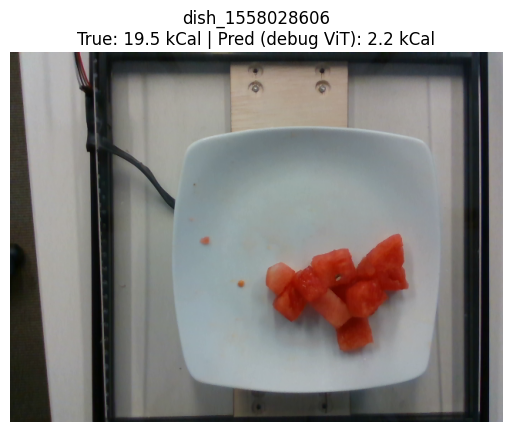


Note: this prediction comes from a model trained on a very small debug subset.
For portfolio-quality performance, you'll later:
- Train on the full Nutrition5k train split (new notebook, e.g. 02_full_training_colab.ipynb).
- Potentially unfreeze more of the backbone and tune hyperparameters.



In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Pick a random test dish
sample_row = test_df.sample(1, random_state=random.randint(0, 9999)).iloc[0]
sample_id = str(sample_row["dish_id"])
true_cal = float(sample_row["total_calories"])

img_path = OVERHEAD_LOCAL_ROOT / sample_id / "rgb.png"

print("Dish ID:", sample_id)
print("True calories:", true_cal)

# Prepare image for ViT eval
_, eval_transform = get_transforms(image_size=224)
img = Image.open(img_path).convert("RGB")
img_tensor = eval_transform(img).unsqueeze(0).to(device)

vit_model_eval.eval()
with torch.no_grad():
    pred_cal = vit_model_eval(img_tensor).squeeze().item()

print("Predicted calories (ViT, debug checkpoint):", pred_cal)

plt.imshow(img)
plt.axis("off")
plt.title(f"{sample_id}\nTrue: {true_cal:.1f} kCal | Pred (debug ViT): {pred_cal:.1f} kCal")
plt.show()

print(
    "\nNote: this prediction comes from a model trained on a very small debug subset.\n"
    "For portfolio-quality performance, you'll later:\n"
    "- Train on the full Nutrition5k train split (new notebook, e.g. 02_full_training_colab.ipynb).\n"
    "- Potentially unfreeze more of the backbone and tune hyperparameters.\n"
)